# XGBoost Classifier


In this section we will use the soo called XGBoost library to build a classifier, to use the costumer information to predict the probable costumer to comply in the next marketing campaing. This algorithm was chosen, considering its high performance on both computational and accuracy manners.

## Reading the DataSet

In [1]:

import pandas as pd

data_path = './ifood-data-business-analyst-test/ml_project1_data.csv'
dataset = pd.read_csv(data_path)


## Preprocessing 

Here we need to provide a simple preprocess to the data to remove possible non informative data, to create information fields that are more suitable for interpretation, some encoding of the features (since some are categorical), also we will make some normalization on the data to avoid over weighting errors and so on... 

> Notice that most functions to do the preprocessing here are implemented in a separated code, since it could be used for other models, and for later analysis.

In [2]:
from utils import *

### Pipeline

The preprocessing pipeline, for the XGBoost classification algorithm will be the one, as follows:

- `Step #1` First we will replace some fields with more interpretable information (Birth date => Age, Customer Registration => Persistence, ...)

- `Step #2` Then we are going to replace the categorical data set with an encoded one (categorical variables => numerical variables)

- `Step #3` Then some non informative features will be dropped from the analysis, _e.g._ features that are constant in all samples (which does not provide any information)

- `Step #4` Since we have only 24 samples with NaN (or null) values, we can drop those from the dataset, instead of concerning with interpolation and so on...

In [3]:

dataset = support.replaceFields(dataset)             # Step #1

dataset, encoders = support.encodeDataSet(dataset)   # Step #2

dataset = support.dropNonInformative(dataset)        # Step #3

df = dataset.dropna()                                # Step #4


Features dropped: ['Z_CostContact', 'Z_Revenue']


Here we have some particular processing of the data for this particular XGBoost classifier algorithm. Notice that the dataset is not balanced between `1` and `0` on the output... Actually it is a proportion close to 10% of `1`/`0`. Therefore, something must be done to deal with the unbalanced dataset. Here we are not doing a simple error weighting using the output data proportions... We will use a randomized sample technique, the reason is:

> _Without knowing depply the fenomenom, a simple approach of just weighting the error proportionally can be very dangerous, even though it is more straightforward. The reason behind this is related to the fact that you are only weighting the data based on the variance of the output feature, and it is not considering how that weighting will behave on the other features variances. If this breaf explanation did not trigger something that made you undestand the idea, please check out my book at [IET Digital Library](https://digital-library.theiet.org/content/books/10.1049/pbce123e_ch3;jsessionid=ji7b4180pudn.x-iet-live-01) where I explain in details every math behind this resolution._

In summary, we will first build the regression problem (yes!! For mathematicians the classification is a binary regression problem... It is common sense to say that regression, is when one wants to fit a curve to the data, that is actually a linear regression) as something close to the structure:

$$y(k) = f(\phi(k), \theta)$$

After we can normalize the data, by just making it fit the the group $[0, 1]$. Notice that we do not want to normalize the variance of each feature... Since the eventual birth of the deep searching algorithms, where most of them use stochastic searching algorithms (simillar to the old annealing, brunch and bound ...), the noramlization of the variance usually removes some scotachastic properties (in a commom sense, removes some part of the randomicity pattern) of the feature. 

Therefore, after normalizing we will balance the data accordenlly with the description provided before by randomly selecting variables to make shure that we have 50% `1`s and 50% `0`s. Of course this will reduce the dataset, but one will see that with stochastic search algorithms, such as the one used by XGBoost, there will not compromise the results.

In [4]:

import numpy as np

# Creating the regression format
phi = df.loc[:, ~df.columns.isin(['Response', 'ID'])].to_numpy()
target = df["Response"].to_numpy()

# Normalization
max_vals = np.amax(phi, axis=0)
min_vals = np.amin(phi, axis=0)
phi_n = (phi - max_vals) / (max_vals - min_vals)

# Balancing the data
X, y = support.balanceDataSet(phi_n, target)


### Test and Train data

Here we have a simple segregation of the preprocessed dataset into train and test.

In [5]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)


## Hyper parameters

Here we will tune the model hyper parameters using a particular algorithm that I usually enjoy, the annealing search. This algorithm actually uses a stochastic search (random search) based on the information entropy of the data, and is actually a global optimization algorithm. This means that it does not use derivatives to search for the optimum set of hyper parameters, it actually is something of a grid search where at each iteration the next set of hyper parameters are not defined by a grid relation, but actually by its randomicity probability of encreasing the information (entropy) of the error of the function that it wants to minimize. And believe it or not, it always finds the optimum set inside the provided restrictions. It is pretty cool!!

So to use it, we must define some bounderies for the parameters that we want to search, a cost function, that here it is the sum of the false positives (since we want to minimize this in the predictions). Then we just need to pass to the algorithm and wait to search for the best parameter set.

In [6]:

# Creating the parameters bounderies
lower, upper = [1, 1, 0.01], [25, 25, 15]
bounds = zip(lower, upper)

# Run the annealing searching 
pars, res = support.xgbHyperGridSearch(bounds, (y_train, X_train, y_test, X_test))
res # print the annealing search summary


     fun: 0.29428381522100366
 message: ['Maximum number of iteration reached']
    nfev: 12666
    nhev: 0
     nit: 2000
    njev: 0
  status: 0
 success: True
       x: array([4.07016452, 1.26624072, 0.70430411])

## Train model

Then we can use the parameters found to create the best XGBoost model classifier...

In [7]:

import xgboost as xgb

# Create the model
model = xgb.XGBClassifier(max_depth=pars[0], min_child_weight=pars[1], gamma=pars[2])
# Train the model
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='logloss', 
          verbose=False)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.7043041138126915,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

## Model Results

Then here we can build some visualizations to show the results. The first one is the fitting with the testing data, using the confusion matrix to make sure the model is consistent. 

> Remember that this data set is balanced, and therefore is a more honnest result, then the second one that will be shown.

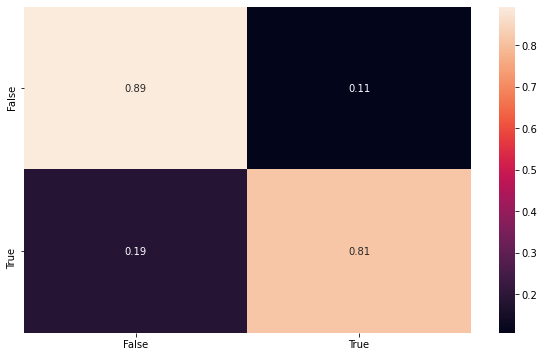

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

index = ['False','True']  
cm_df = pd.DataFrame(conf_mat,index,index)                      

plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)


Here we can show the classification performance of the unbalaced dataset, using all samples, to be sure that the model maintain its consistency.

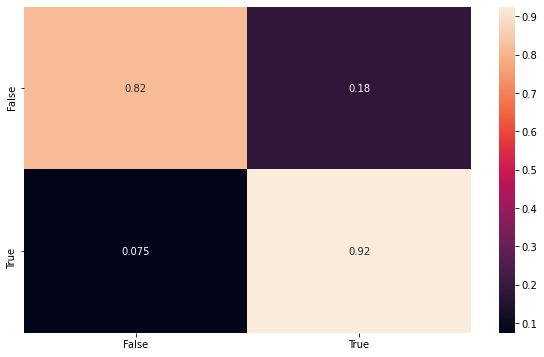

In [9]:

y_pred = model.predict(phi_n)
conf_mat = confusion_matrix(target, y_pred, normalize='true')

index = ['False','True']  
cm_df = pd.DataFrame(conf_mat,index,index)                      

plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)
